Copyright 2019 Google LLC.
SPDX-License-Identifier: Apache-2.0

**Notebook Version** - 1.0.0

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import json

# Case Study: Prevalence of Obesity in 500 US Cities

Obesity is well known to correlate with health factors such as high blood pressure, but is also known to correlate with economic factors such as low-income, unemployment, etc [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3198075/)[[2]](https://www.ncbi.nlm.nih.gov/pubmed/26562758). The Center for Disease Control (CDC) provides prevalence percentages on health conditions such as [obesity](https://browser.datacommons.org/kg?type=Observation&dcid=dc/o/znbdp41vejt84&r=0), [high blood pressure](https://browser.datacommons.org/kg?type=Observation&dcid=dc/o/wsj0e6pjndf74&r=0), and [high cholesterol](https://browser.datacommons.org/kg?type=Observation&dcid=dc/o/5l1fm8514pgxc&r=0) for approximately 500 major cities in the US (e.g. [San Francisco](https://browser.datacommons.org/kg?type=City&dcid=dc/3eknvn2), [New York](https://browser.datacommons.org/kg?type=City&dcid=dc/prehdd2&r=1), and [Austin](https://browser.datacommons.org/kg?type=City&dcid=dc/khxv4f2&r=1)). Meanwhile, the US Bureau of Labor Statistics provides [unemployment rates]() while the US Census provides [poverty rates]() for most cities across the United States. 

Even though these statistics come from different datasets across different government agencies with different storage formats, dataCommons surfaces each  of these in a single, uniform knowledge graph. In fact, you can see this in the [browser](https://browser.datacommons.org/kg?dcid=dc/re83dx3&r=0) by looking at the *provenance* column. Let's use the data in dataCommons to create a linear regression model that incorporates variables:

- Prevalence of high blood pressure
- Unemployment rate
- Percent of population living with income below the poverty line

to predict the prevalence of obesity in the 500 cities that the CDC provides data for. One thing you may note is that the US Census also provides employment statistics (you can see this by navigating to the "employment" and "employmentStatus" sections for [San Francisco](https://browser.datacommons.org/kg?type=City&dcid=dc/3eknvn2) and observing the different provenances). Our choice of using statistics from the Bureau of Labor Statistics is purely demonstrative, but it would be interesting to see if similar results can be reproduced using US Census employment statistics. 

In [5]:
!pip install --upgrade --quiet git+https://github.com/datacommonsorg/api-python.git@stable-1.x

import datacommons as dc

We will also need to provide the API with an API key. See the [Analyzing Statistics in Data Commons Using the Python API](https://colab.research.google.com/drive/1ZNXTHu3J0W3vo9Mg3kNUpk0hnD6Ce1u6#scrollTo=ijxoBhFHjo3Z) to see how to set this up for a Colab Notebook.

In [6]:
# Mount the Drive
drive.mount('/content/drive', force_remount=True)

# REPLACE THIS with the path to your key.
key_path = '/content/drive/My Drive/DataCommons/secret.json'

# Read the key in and provide it to the Data Commons API
with open(key_path, 'r') as f:
  secrets = json.load(f)
  dc.set_api_key(secrets['dc_api_key'])

Mounted at /content/drive


To get started, we'll need the cities that CDC provides data for. We've listed the DCIDs of all cities with CDC obesity prevalence statistics and stored it as a variable `city_dcids`. For now we will hide this cell!

In [0]:
#@title
city_dcids = [
    "geoId/5370000", "geoId/0524550", "geoId/0820000", 
    "geoId/3502000", "geoId/0665000", "geoId/1239550", 
    "geoId/2148006", "geoId/1232000", "geoId/1757225", 
    "geoId/0622804", "geoId/0807850", "geoId/4848072", 
    "geoId/3921000", "geoId/0680000", "geoId/3650617", 
    "geoId/4813024", "geoId/0644000", "geoId/0918430", 
    "geoId/5147672", "geoId/3345140", "geoId/4856000", 
    "geoId/1714351", "geoId/1982425", "geoId/2674900", 
    "geoId/1258050", "geoId/4943660", "geoId/0541000", 
    "geoId/0659451", "geoId/1269700", "geoId/0616350", 
    "geoId/0653980", "geoId/4459000", "geoId/0650258", 
    "geoId/0622230", "geoId/4845744", "geoId/0662938", 
    "geoId/0150000", "geoId/0673080", "geoId/3725580", 
    "geoId/0603526", "geoId/0846465", "geoId/1656260", 
    "geoId/2523000", "geoId/2241155", "geoId/0427820", 
    "geoId/2970000", "geoId/0622020", "geoId/3728000", 
    "geoId/5101000", "geoId/0681204", "geoId/1851876", 
    "geoId/1768003", "geoId/4224000", "geoId/4815976", 
    "geoId/2688940", "geoId/0606000", "geoId/0454050", 
    "geoId/3006550", "geoId/1751622", "geoId/4748000", 
    "geoId/5164000", "geoId/1077580", "geoId/0681666", 
    "geoId/5548000", "geoId/5584250", "geoId/0681344", 
    "geoId/0623182", "geoId/2915670", "geoId/1368516", 
    "geoId/4260000", "geoId/0615044", "geoId/1765000", 
    "geoId/4819000", "geoId/1921000", "geoId/1212875", 
    "geoId/3413690", "geoId/1253000", "geoId/0827425", 
    "geoId/0603666", "geoId/0616000", "geoId/2255000", 
    "geoId/5539225", "geoId/3710740", "geoId/3663000", 
    "geoId/4843888", "geoId/2567000", "geoId/2646000", 
    "geoId/2954074", "geoId/1150000", "geoId/0668084", 
    "geoId/3665508", "geoId/3436000", "geoId/1270600", 
    "geoId/0980000", "geoId/2706616", "geoId/4548535", 
    "geoId/1840788", "geoId/0677000", "geoId/1779293", 
    "geoId/2836000", "geoId/4983470", "geoId/0636770", 
    "geoId/2680700", "geoId/4803000", "geoId/1239425", 
    "geoId/2509000", "geoId/2036000", "geoId/0446000", 
    "geoId/2582000", "geoId/0816000", "geoId/0477000", 
    "geoId/0616532", "geoId/0658072", "geoId/4856348", 
    "geoId/2511000", "geoId/5303180", "geoId/0877290", 
    "geoId/4847892", "geoId/5305280", "geoId/1257425", 
    "geoId/0653000", "geoId/3912000", "geoId/2649000", 
    "geoId/1912000", "geoId/0639892", "geoId/4957300", 
    "geoId/4962470", "geoId/0680812", "geoId/0640130", 
    "geoId/1822000", "geoId/4147000", "geoId/0660466", 
    "geoId/1823278", "geoId/2758000", "geoId/0681554", 
    "geoId/1207875", "geoId/0135896", "geoId/3702140", 
    "geoId/4261000", "geoId/1207300", "geoId/2669035", 
    "geoId/4810768", "geoId/0680854", "geoId/5135000", 
    "geoId/0535710", "geoId/1712385", "geoId/0107000", 
    "geoId/0655156", "geoId/1772000", "geoId/4419180", 
    "geoId/4751560", "geoId/0630000", "geoId/3916000", 
    "geoId/5566000", "geoId/0614218", "geoId/5367000", 
    "geoId/2038900", "geoId/2545000", "geoId/0659920", 
    "geoId/1938595", "geoId/0648256", "geoId/3825700", 
    "geoId/0845970", "geoId/4752006", "geoId/4841464", 
    "geoId/0678582", "geoId/0613392", "geoId/3260600", 
    "geoId/4041850", "geoId/4819972", "geoId/4827000", 
    "geoId/3240000", "geoId/0608786", "geoId/0636000", 
    "geoId/4714000", "geoId/5357745", "geoId/4105800", 
    "geoId/0455000", "geoId/1703012", "geoId/1367284", 
    "geoId/4848804", "geoId/0665042", "geoId/0684200", 
    "geoId/1827000", "geoId/1714000", "geoId/1342425", 
    "geoId/5010675", "geoId/4513330", "geoId/0611194", 
    "geoId/0621712", "geoId/0650076", "geoId/3712000", 
    "geoId/0660018", "geoId/1831000", "geoId/4982950", 
    "geoId/4715160", "geoId/1243975", "geoId/4822660", 
    "geoId/0843000", "geoId/5531000", "geoId/5167000", 
    "geoId/4105350", "geoId/4123850", "geoId/1652120", 
    "geoId/0602000", "geoId/4810912", "geoId/0628000", 
    "geoId/0804000", "geoId/5176432", "geoId/2621000", 
    "geoId/2754880", "geoId/4561405", "geoId/4829000", 
    "geoId/1973335", "geoId/5380010", "geoId/0646898", 
    "geoId/4740000", "geoId/2717000", "geoId/0668000", 
    "geoId/1230000", "geoId/5157000", "geoId/0624680", 
    "geoId/1216725", "geoId/0651182", "geoId/0636546", 
    "geoId/0523290", "geoId/0669070", "geoId/0137000", 
    "geoId/0659962", "geoId/3128000", "geoId/0613210", 
    "geoId/4801924", "geoId/0812815", "geoId/0485540", 
    "geoId/0613214", "geoId/4009050", "geoId/0600884", 
    "geoId/0662000", "geoId/1245025", "geoId/3961000", 
    "geoId/2629000", "geoId/4804000", "geoId/3570500", 
    "geoId/5182000", "geoId/4841980", "geoId/0611530", 
    "geoId/3722920", "geoId/2146027", "geoId/2052575", 
    "geoId/1759000", "geoId/3474000", "geoId/1224000", 
    "geoId/0648354", "geoId/4861796", "geoId/1254200", 
    "geoId/15003", "geoId/5305210", "geoId/4269000", 
    "geoId/4807000", "geoId/4879000", "geoId/0629000", 
    "geoId/0656000", "geoId/2935000", "geoId/2071000", 
    "geoId/4835000", "geoId/1235000", "geoId/4075000", 
    "geoId/4853388", "geoId/0617918", "geoId/4055000", 
    "geoId/1871000", "geoId/5116000", "geoId/0668196", 
    "geoId/5374060", "geoId/4830464", "geoId/2537490", 
    "geoId/1238250", "geoId/2360545", "geoId/0832155", 
    "geoId/0664000", "geoId/4801000", "geoId/0647766", 
    "geoId/0672016", "geoId/2684000", "geoId/4858016", 
    "geoId/0465000", "geoId/3563460", "geoId/0646842", 
    "geoId/3775000", "geoId/0682996", "geoId/1707133", 
    "geoId/2627440", "geoId/2239475", "geoId/2603000", 
    "geoId/5335415", "geoId/1723074", "geoId/0632548", 
    "geoId/0670000", "geoId/1836003", "geoId/0669000", 
    "geoId/5168000", "geoId/3268400", "geoId/3774440", 
    "geoId/3457000", "geoId/2964550", "geoId/4876000", 
    "geoId/5414600", "geoId/0656700", "geoId/3539380", 
    "geoId/0657792", "geoId/0670098", "geoId/0952000", 
    "geoId/0666000", "geoId/0973000", "geoId/0639496", 
    "geoId/0566080", "geoId/0600562", "geoId/3673000", 
    "geoId/1245060", "geoId/0669196", "geoId/3350260", 
    "geoId/0862000", "geoId/2676460", "geoId/0955990", 
    "geoId/1810342", "geoId/0626000", "geoId/1738570", 
    "geoId/3137000", "geoId/4052500", "geoId/4857200", 
    "geoId/3601000", "geoId/0608954", "geoId/0619766", 
    "geoId/3456550", "geoId/3474630", "geoId/4131250", 
    "geoId/4164900", "geoId/1319000", "geoId/2555745", 
    "geoId/3714100", "geoId/3231900", "geoId/0602364", 
    "geoId/4550875", "geoId/0427400", "geoId/1369000", 
    "geoId/1225175", "geoId/0654652", "geoId/1304204", 
    "geoId/4202000", "geoId/3918000", "geoId/2829700", 
    "geoId/2270000", "geoId/5367167", "geoId/0937000", 
    "geoId/4263624", "geoId/4845384", "geoId/5613900", 
    "geoId/2941348", "geoId/0682590", "geoId/1258715", 
    "geoId/4874144", "geoId/0682954", "geoId/1825000", 
    "geoId/0908000", "geoId/0633434", "geoId/0653896", 
    "geoId/4955980", "geoId/0151000", "geoId/0645484", 
    "geoId/1216475", "geoId/3728080", "geoId/2545560", 
    "geoId/0883835", "geoId/3410000", "geoId/2642160", 
    "geoId/2537000", "geoId/4848768", "geoId/1724582", 
    "geoId/4965330", "geoId/0627000", "geoId/0652526", 
    "geoId/0649670", "geoId/4870808", "geoId/4206088", 
    "geoId/1919000", "geoId/3755000", "geoId/0636448", 
    "geoId/0641992", "geoId/5553000", "geoId/0684550", 
    "geoId/0675000", "geoId/5323515", "geoId/3684000", 
    "geoId/2404000", "geoId/0613588", "geoId/4652980", 
    "geoId/3651000", "geoId/2562535", "geoId/1718823", 
    "geoId/1245000", "geoId/2507000", "geoId/0604982", 
    "geoId/0664224", "geoId/2240735", "geoId/0678120", 
    "geoId/3451000", "geoId/2751730", "geoId/0667000", 
    "geoId/4659020", "geoId/5363000", "geoId/2622000", 
    "geoId/1255775", "geoId/4863500", "geoId/0685292", 
    "geoId/0950370", "geoId/1217200", "geoId/0643000", 
    "geoId/3734200", "geoId/4837000", "geoId/0412000", 
    "geoId/4842508", "geoId/1303440", "geoId/4967000", 
    "geoId/0669088", "geoId/0660620", "geoId/0203000", 
    "geoId/1702154", "geoId/2686000", "geoId/4806128", 
    "geoId/0669084", "geoId/1304000", "geoId/1301052", 
    "geoId/0649270", "geoId/1210275", "geoId/0613014", 
    "geoId/4474300", "geoId/5322640", "geoId/2743000", 
    "geoId/0803455", "geoId/1271000", "geoId/1380508", 
    "geoId/0602252", "geoId/4134100", "geoId/4159000", 
    "geoId/3901000", "geoId/1263000", "geoId/3421000", 
    "geoId/4817000", "geoId/1245975", "geoId/0404720", 
    "geoId/4454640", "geoId/0633000", "geoId/3611000", 
    "geoId/5156000", "geoId/3977000", "geoId/4845000", 
    "geoId/0633182", "geoId/0668252", "geoId/3731400", 
    "geoId/1706613", "geoId/2634000", "geoId/4839148", 
    "geoId/4516000", "geoId/2707966", "geoId/1349000", 
    "geoId/2053775", "geoId/1214400", "geoId/4864472", 
    "geoId/2938000", "geoId/3251800", "geoId/2965000", 
    "geoId/4865000", "geoId/3649121", "geoId/4827684", 
    "geoId/0471510", "geoId/1254000", "geoId/4023200", 
    "geoId/3050200", "geoId/1276600", "geoId/0660102", 
    "geoId/0644574", "geoId/3719000", "geoId/1608830", 
    "geoId/0653322", "geoId/5502375", "geoId/2534550", 
    "geoId/4967440", "geoId/0473000", "geoId/5335275", 
    "geoId/3915000", "geoId/1805860", "geoId/4824000", 
    "geoId/4805000", "geoId/2079000", "geoId/2205000", 
    "geoId/0624638", "geoId/3988000", "geoId/0668378", 
    "geoId/0177256", "geoId/0680238",
]

We then initialize a `pandas.DataFrame` with the dcids in this list.

In [8]:
# Create the Pandas DataFrame 
data = pd.DataFrame({'City': city_dcids})

# Get the name of each city
data['CityName'] = dc.get_property_values(data['City'], 'name')
data = dc.flatten_frame(data)

# Show the top five rows
data.head(5)

,City,CityName
0,geoId/5370000,Tacoma
1,geoId/0524550,Fort Smith
2,geoId/0820000,Denver
3,geoId/3502000,Albuquerque
4,geoId/0665000,San Bernardino


### Querying for all Statistics

Let's start by querying for all our statistics. If you have not already, take a look at this [notebook](https://colab.research.google.com/drive/1ZNXTHu3J0W3vo9Mg3kNUpk0hnD6Ce1u6) explaining how to query for StatisticalPopulations and Observations. 

In [9]:
# Prevalence of obesity
data['ObesityPop'] = dc.get_populations(
    data['City'],
    'Person',
    constraining_properties={
        'unhealthyBehavior': 'CDC_Obesity'
    }
)
data['Obesity'] = dc.get_observations(
    data['ObesityPop'],
    'prevalence',
    'measuredValue',
    '2015',
    measurement_method='CDC_CrudePrevalence'
)

# Prevalence of high blood pressure
data['HighBpPop'] = dc.get_populations(
    data['City'],
    'Person',
    constraining_properties={
        'healthOutcome': 'CDC_BPHigh'
    }
)
data['HighBp'] = dc.get_observations(
    data['HighBpPop'],
    'prevalence',
    'measuredValue',
    '2015',
    measurement_method='CDC_CrudePrevalence'
)

# Population of all persons
data['AllPersonsPop'] = dc.get_populations(data['City'], 'Person')

# Total persons count 
data['PersonCount'] = dc.get_observations(
    data['AllPersonsPop'],
    'count',
    'measuredValue',
    '2015',
    measurement_method='CenusACS5yrSurvey'
)

# Unemployment rate
data['Unemployment'] = dc.get_observations(
    data['AllPersonsPop'],
    'unemploymentRate',
    'measuredValue',
    '2015',
    observation_period='P1Y',
    measurement_method='BLSSeasonallyUnadjusted'
)

# Count of persons living below the poverty line
data['PovertyPersonsPop'] = dc.get_populations(
    data['City'],
    'Person',
    constraining_properties={
        'povertyStatus': 'BelowPovertyLevelInThePast12Months'
    }
)
data['PovertyCount'] = dc.get_observations(
    data['PovertyPersonsPop'],
    'count',
    'measuredValue',
    '2015',
    measurement_method='CenusACS5yrSurvey'
)

# Display the first five rows.
data.head(5)

,City,CityName,ObesityPop,Obesity,HighBpPop,HighBp,AllPersonsPop,PersonCount,Unemployment,PovertyPersonsPop,PovertyCount
0,geoId/5370000,Tacoma,dc/p/ygz97bz3qrl68,32.1,dc/p/061211lndk972,32.1,dc/p/v2z7yr9e9m7t4,203481.0,6.8,dc/p/9r3lcy246fb72,35674.0
1,geoId/0524550,Fort Smith,dc/p/0wzp84d2rghp4,31.7,dc/p/jyfmgsp4wlsn4,37.9,dc/p/qep2q2lcc3rcc,87603.0,4.8,dc/p/3vl1zg91yczx7,23080.0
2,geoId/0820000,Denver,dc/p/z1dpmq8jnmhdc,20.4,dc/p/71jjtd68z1tl7,23.7,dc/p/gmw3cn8tmsnth,649654.0,3.7,dc/p/r2svxn0qs9nk8,110299.0
3,geoId/3502000,Albuquerque,dc/p/2tbc81tpz0s26,25.7,dc/p/0wp70nnwevmh2,26.5,dc/p/xjngmjh589vn5,556092.0,5.8,dc/p/rzvgzt78nzer7,105617.0
4,geoId/0665000,San Bernardino,dc/p/3hn9s9kz9gezg,34.6,dc/p/z8jneb443gyg9,31.5,dc/p/92cxc027krdcd,214112.0,8.2,dc/p/001d2p6867d3g,68990.0


### Cleaning the Data

Great! We have all the statistics we'll need for this case study queried from three different data sources without having to write additional code to perform the joins. However, we'll still need to perform three data cleanup tasks to prepare the data for analysis:

1. Select the column of city names and all observation columns.
2. Convert the observation columns to numerical types. Since dataCommons is still in its early release stage, there are a couple of oddities such as how numerical observations are stored as text values!
3. Remove any missing rows with missing values.

Let's generate the final dataframe.

In [10]:
# Get the cleaned table
cleaned = dc.clean_frame(data)

# Remove population columns and compute the poverty rate
cleaned = cleaned[['CityName', 'Obesity', 'HighBp', 'Unemployment', 'PersonCount', 'PovertyCount']]
cleaned['PovertyRate'] = cleaned['PovertyCount'] / cleaned['PersonCount'] * 100

# Display the table
cleaned.head(5)

,CityName,Obesity,HighBp,Unemployment,PersonCount,PovertyCount,PovertyRate
0,Tacoma,32.1,32.1,6.8,203481.0,35674.0,17.531858
1,Fort Smith,31.7,37.9,4.8,87603.0,23080.0,26.346130
2,Denver,20.4,23.7,3.7,649654.0,110299.0,16.978115
3,Albuquerque,25.7,26.5,5.8,556092.0,105617.0,18.992721
4,San Bernardino,34.6,31.5,8.2,214112.0,68990.0,32.221454


### Exploring the Data

Now's a good time to explore how each variable (high blood pressure prevalence, unemployment rate, and poverty rate) correlate with obesity prevalence. As stated before, previous research has shown that each of these variables tend to correlate positively with the prevalence of Obesity. Does our data show this?

<Figure size 432x288 with 0 Axes>

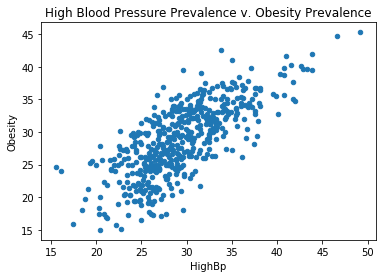

In [11]:
# Plot Bphigh vs. Obesity
plt.figure(figsize=(6,4))
cleaned.plot.scatter(x='HighBp', y='Obesity')
plt.title('High Blood Pressure Prevalence v. Obesity Prevalence')

# Show the plot
plt.show()

<Figure size 432x288 with 0 Axes>

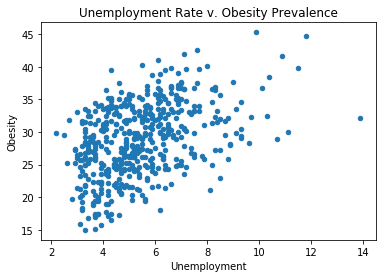

In [12]:
# Plot Unemployment with Obesity
plt.figure(figsize=(6,4))
cleaned.plot.scatter(x='Unemployment', y='Obesity')
plt.title('Unemployment Rate v. Obesity Prevalence')

# Show the plot
plt.show()

<Figure size 432x288 with 0 Axes>

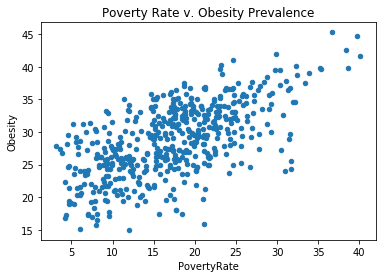

In [13]:
# Plot PovertyRate with Obesity
plt.figure(figsize=(6,4))
cleaned.plot.scatter(x='PovertyRate', y='Obesity')
plt.title('Poverty Rate v. Obesity Prevalence')

# Show the plot
plt.show()

Looks like each of variable does correlate positively with obesity prevalence.

### Modeling the Data

We'll be predicting the prevalence of obesity with the following linear model.

<br>
$$f_\theta(x) = \theta_0 + \theta_1 (\text{high blood pressure}) + \theta_2 (\text{unemployment}) + \theta_3(\text{poverty rate})$$
<br>

Let's start by creating our training and test sets. We'll then train a linear regression model using Scikit learn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [14]:
X = cleaned[['HighBp', 'Unemployment', 'PovertyRate']]
Y = cleaned[['Obesity']]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)

print('Model Intercept: {}'.format(model.intercept_))
print('Model Coefficients: {}'.format(model.coef_))

Model Intercept: [4.85067402]
Model Coefficients: [[ 0.66873351 -0.14130964  0.29417318]]


### Analyzing the Model

We now have a trained model, but how well does it perform?

In [15]:
def mse(y_pred, y_true):
    """ Compute the mean squared error of 'y_pred' and 'y_true'. """
    return float(np.sum((y_pred - y_true) ** 2)) / len(y_pred)

train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

print('Training Error: {}'.format(mse(train_pred, y_train)))
print('Test Error: {}'.format(mse(test_pred, y_test)))

Training Error: 10.228031794227281
Test Error: 12.858870785996542


We can also display a plot of the residuals

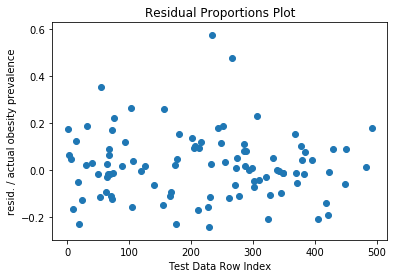

In [16]:
y_res = (test_pred - y_test) / y_test

# Plot the results
plt.title("Residual Proportions Plot")
plt.xlabel("Test Data Row Index")
plt.ylabel("resid. / actual obesity prevalence")
plt.scatter(y_res.index, y_res['Obesity'])
plt.show()

How well does your model perform? We were able to achieve an MSE for the test set of approximately 10% points from the observed obesity prevalence. Our model was also able to fit the data with the max residual bounded by +/- 30%, which for a simple model considering only three explanatory variables isn't so bad.

## Conclusion

Congratulations! Rather than spending a couple of hours just searching for and joining datasets from the CDC, Bureau of Labor Statistics, and US Census Bureau, you've spent one lab session querying dataCommons for the same data and, on top of that, using it to build a linear model. Hopefully dataCommons has made the time-to-analysis much shorter! 

You've also created a basic model to predict the prevalence of obesity in approximately 500 states using intuition from a long line of research. The model you've created only uses three explanatory variables, so even though it's not the most accurate at predicting obesity prevalence, it's possible that it can be improved by adding more variables. Obesity is also known to correlate with factors such as [high cholesterol](https://browser.datacommons.org/kg?dcid=dc/p/ff59srlmxrr56) and [diabetes](https://browser.datacommons.org/kg?dcid=dc/p/j8ltt5t5r9p75), but with the data in dataCommons, we can even consider asking if obesity correlates with stranger factors such as

- How many universities recognized by [collegescorecard](https://collegescorecard.ed.gov/data/) dataset are contained in a given city 
- The incidence rate of property arson
- The average snowfall in inches

Does adding these variables into your model improve accuracy? Can you think of other variables that correlate with obesity? 